In [1]:
%%bash
# Download TF checkpoints in data/models folder

wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvzf inception_v3_2016_08_28.tar.gz -C ../../deep_learning/data/models/
rm inception_v3_2016_08_28.tar.gz

wget http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz
tar -xvzf adv_inception_v3_2017_08_18.tar.gz -C ../../deep_learning/data/models/
rm adv_inception_v3_2017_08_18.tar.gz

inception_v3.ckpt
adv_inception_v3.ckpt.data-00000-of-00001
adv_inception_v3.ckpt.index
adv_inception_v3.ckpt.meta


--2018-04-15 05:30:28--  http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.217.48, 2607:f8b0:400a:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.217.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100885009 (96M) [application/x-tar]
Saving to: ‘inception_v3_2016_08_28.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 2.92M 33s
    50K .......... .......... .......... .......... ..........  0% 6.99M 23s
   100K .......... .......... .......... .......... ..........  0% 10.5M 19s
   150K .......... .......... .......... .......... ..........  0% 12.4M 16s
   200K .......... .......... .......... .......... ..........  0% 22.4M 14s
   250K .......... .......... .......... .......... ..........  0% 19.3M 12s
   300K .......... .......... .......... .......... ..........  0% 33.5M 11s
   350K .......... .......... ..

In [11]:
# Reference: https://github.com/marcoancona/DeepExplain/blob/master/examples/inception_tensorflow.ipynb
import pandas as pd
import numpy as np
from sklearn import metrics

import tensorflow as tf
from tensorflow.contrib.slim.nets import inception

from skater.util.dataops import json_validator
from skater.util.image_ops import load_image, show_image, normalize, add_noise
from skater.util.image_ops import in_between, remove_pixels
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_visualizer import visualize

In [2]:
slim = tf.contrib.slim

file_directory = '../../../Skater/build/lib/skater/util/model_specific/imagenet_label.json'
json_data = open(file_directory).read()
json_validator(json_data)

True

In [3]:
resized_img = load_image('../../deep_learning/data/images/pandas.jpg', 299, 299)
input_resized_img = resized_img.reshape((1, 299, 299, 3))

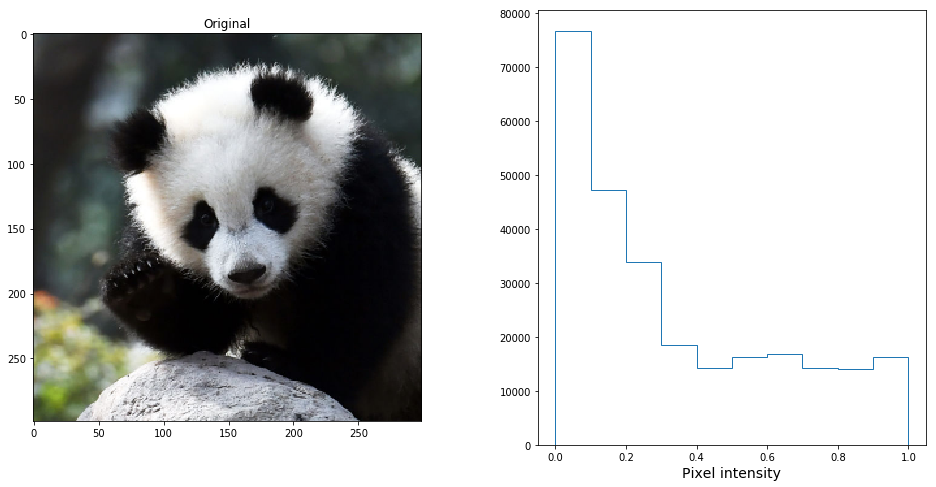

In [5]:
%matplotlib inline
show_image(input_resized_img[0])

In [6]:
# Load Inception V3 model from Tensorflow Slim, restore section
# from checkpoint and run the classifier on the input data
num_classes = 1001

# Select the model here. Use adv_inception_v3 to use the weights of
# an adversarially trained Inception V3. Explanations will be more sparse.

checkpoint = '../../deep_learning/data/models/inception_v3.ckpt'

In [7]:
# Load the labels related to imagenet dataset
import json
tf.reset_default_graph()
sess = tf.Session()
labels = json.loads(json_data)

In [8]:
tf.reset_default_graph()
sess = tf.Session()
# top k predictions
k = 3
with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_resized_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    print(label_prob)
    for ix in index[0]:
        print(labels[str(ix)])

INFO:tensorflow:Restoring parameters from ../../deep_learning/data/models/inception_v3.ckpt
[[9.3464375e-01 1.2197685e-03 6.0174422e-04]]
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
soccer ball
space shuttle


In [9]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X),
    }
    print ("success...")

success...


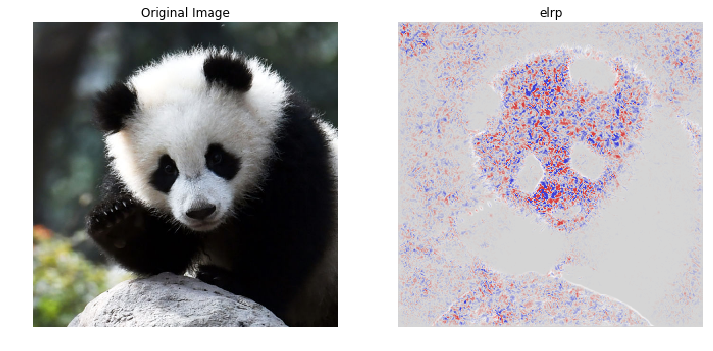

In [10]:
# Plot relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original Image')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)

### Transforming the image to generate adversarial example

2018-04-16 07:03:39,914 - skater.util.image_ops - INFO - Number of pixels matching the condition : 28749
2018-04-16 07:03:39,915 - skater.util.image_ops - INFO - Number of pixels specified to be replaced : 60000


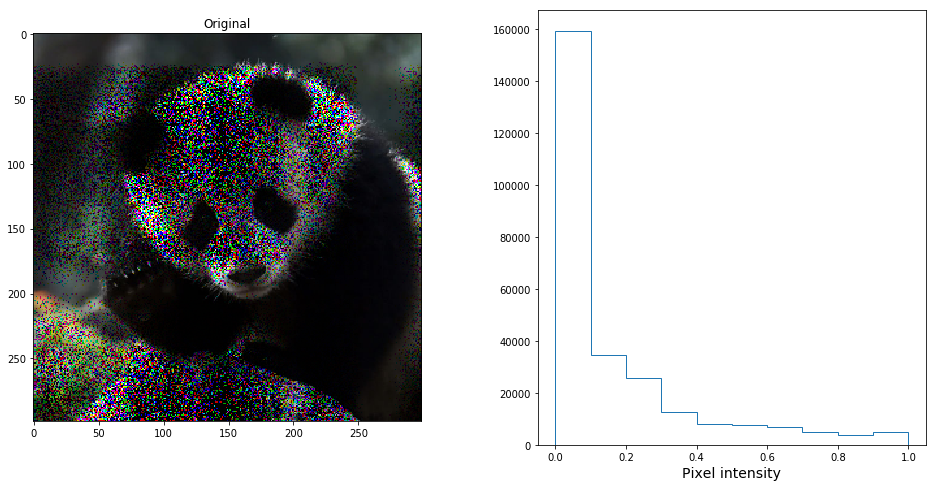

In [31]:
X = input_resized_img[0]
n_in_img = remove_pixels(X, 60000, filtered_pixel=in_between(X, 0.6, 1.))
show_image(n_in_img)

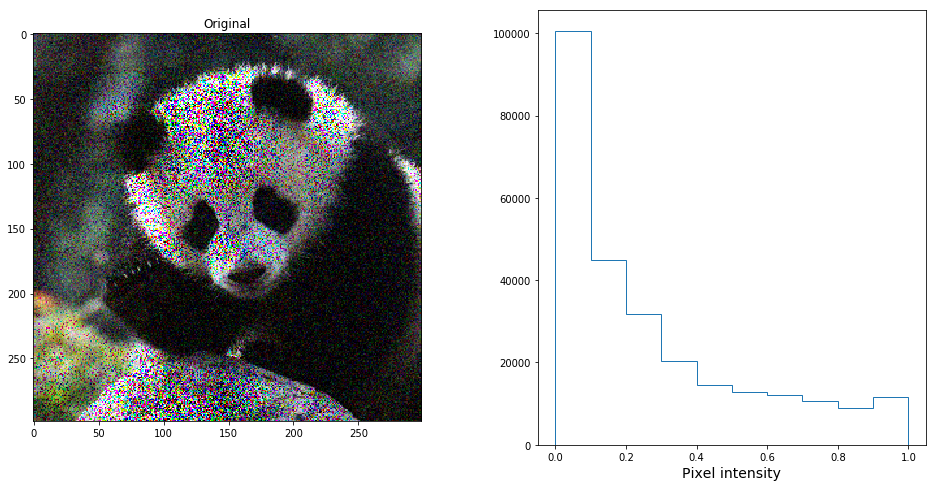

In [28]:
# 1. Gaussian noise
import skimage
with_gaussian_noise = normalize(skimage.util.random_noise(resized_img, mode='gaussian', seed=0))
show_image(with_gaussian_noise.reshape((299, 299, 3)))

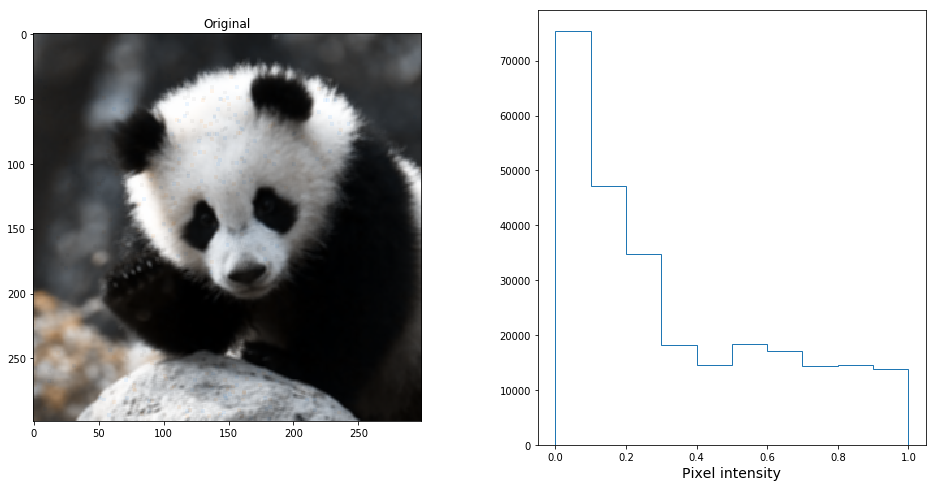

In [14]:
# 2. Trying blurring an image
from scipy import ndimage
blured_image = ndimage.uniform_filter(input_resized_img[0])
show_image(normalize(blured_image))

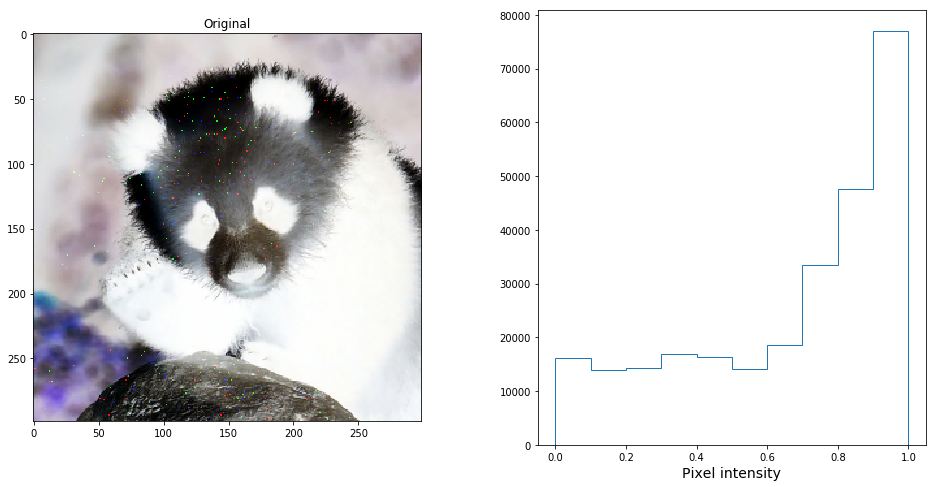

In [15]:
#3. Applying color inversion

from skimage import util
import numpy as np

color_inversion_image = util.invert(input_resized_img[0])
show_image(normalize(color_inversion_image))

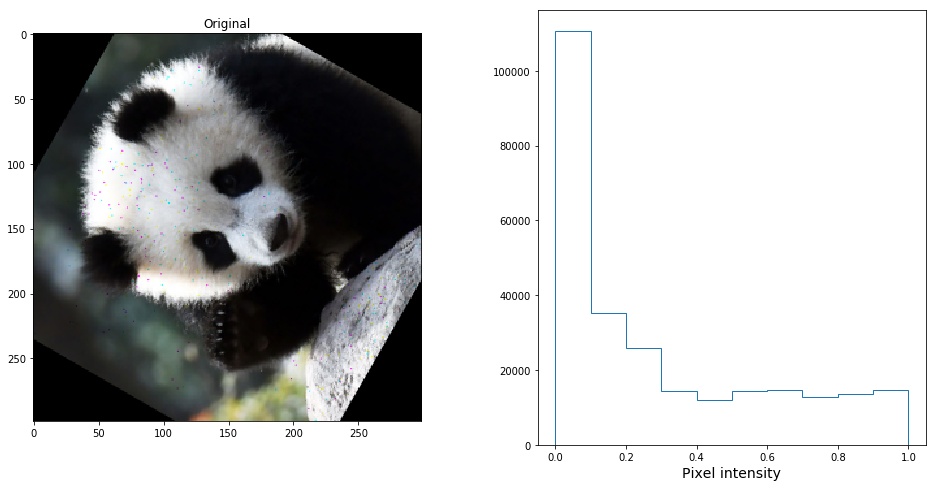

In [16]:
from skimage.transform import rotate

# 4. rotation
image_with_rotation = rotate(input_resized_img[0], 60)

show_image(image_with_rotation)

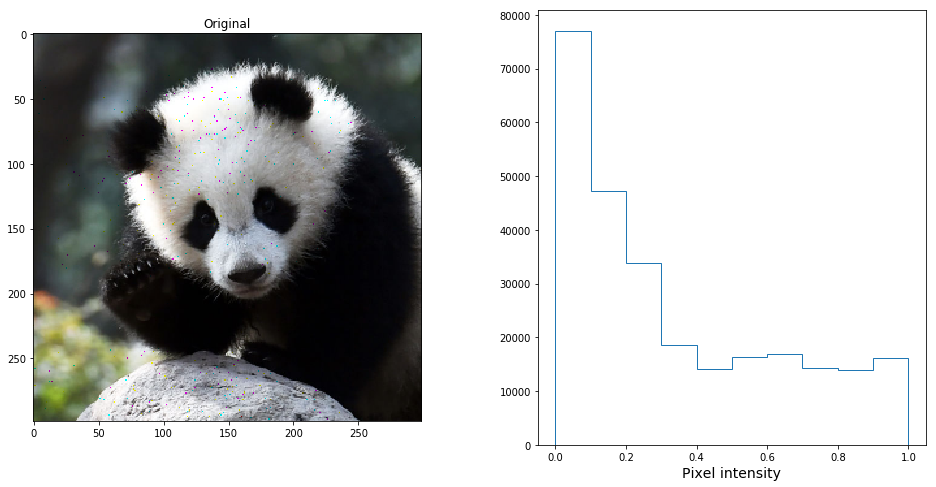

In [17]:
# 5. Rescaling intensity
import numpy as np
from skimage import exposure

v_min, v_max = np.percentile(input_resized_img[0], (0.2, 99.8))
better_contrast = exposure.rescale_intensity(input_resized_img[0], in_range=(v_min, v_max))

show_image(better_contrast)

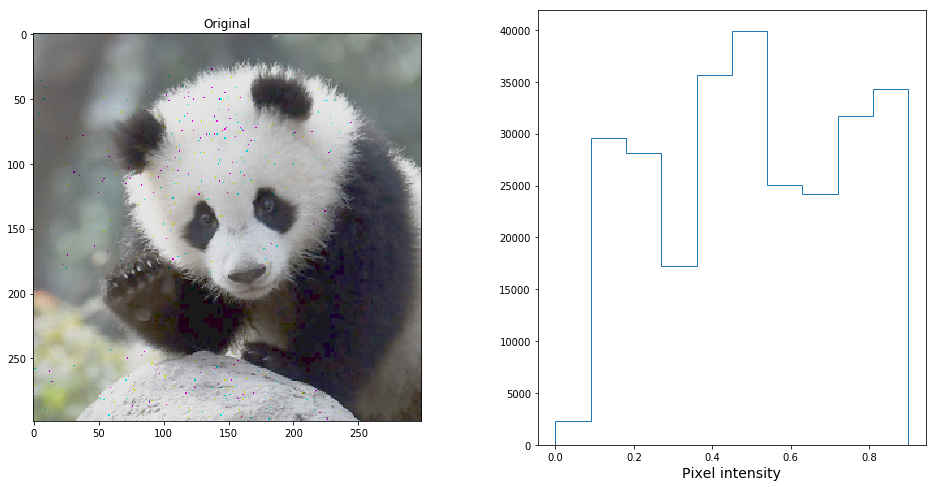

In [18]:
# 6. Gamma correction
adjusted_gamma_image = exposure.adjust_gamma(input_resized_img[0], gamma=0.4, gain=0.9)

show_image(adjusted_gamma_image)

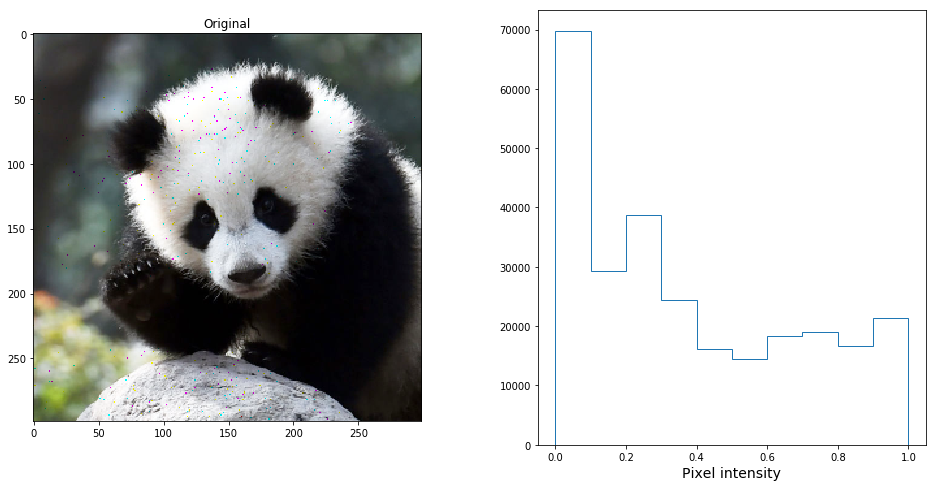

In [19]:
# 7. Log correction
log_correction_image = exposure.adjust_log(input_resized_img[0])
show_image(log_correction_image)

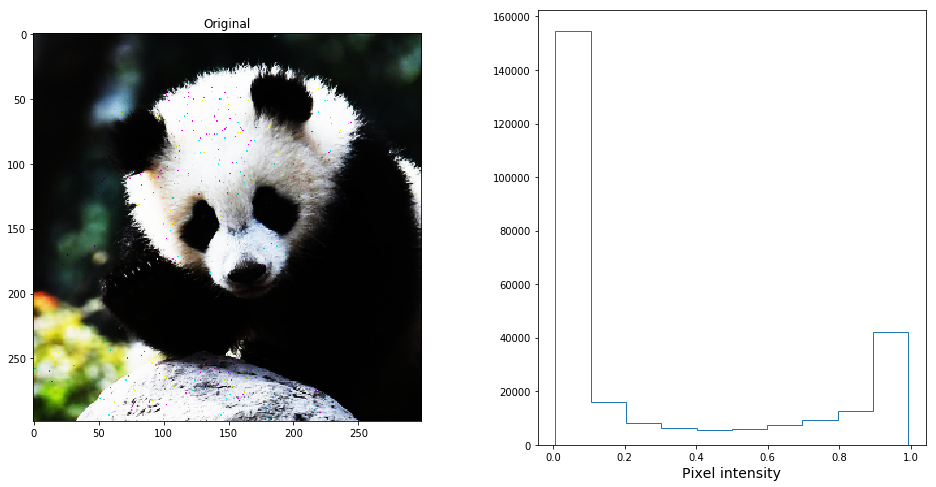

In [20]:
# 8. Sigmoid correction
sigmoid_correction_image = exposure.adjust_sigmoid(input_resized_img[0])
show_image(sigmoid_correction_image)

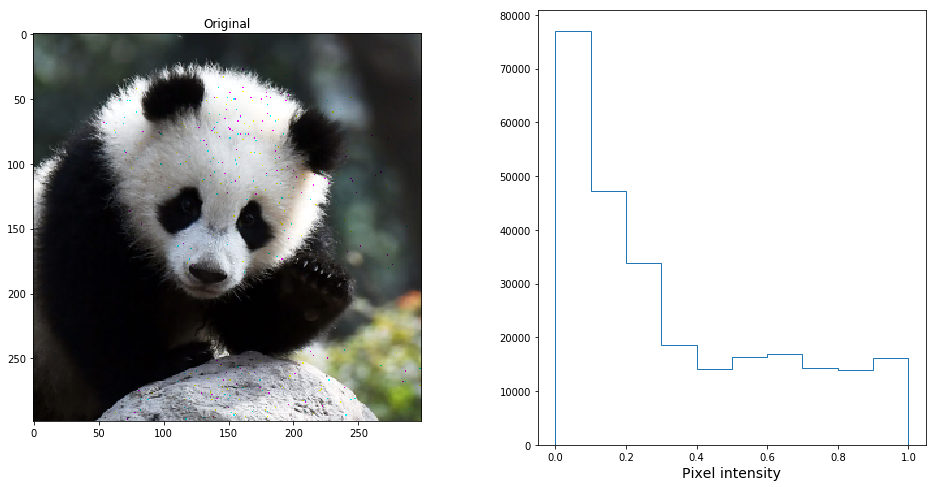

In [21]:
# 9. horizontal flip
horizontal_flip = input_resized_img[0][:, ::-1]
show_image(horizontal_flip)

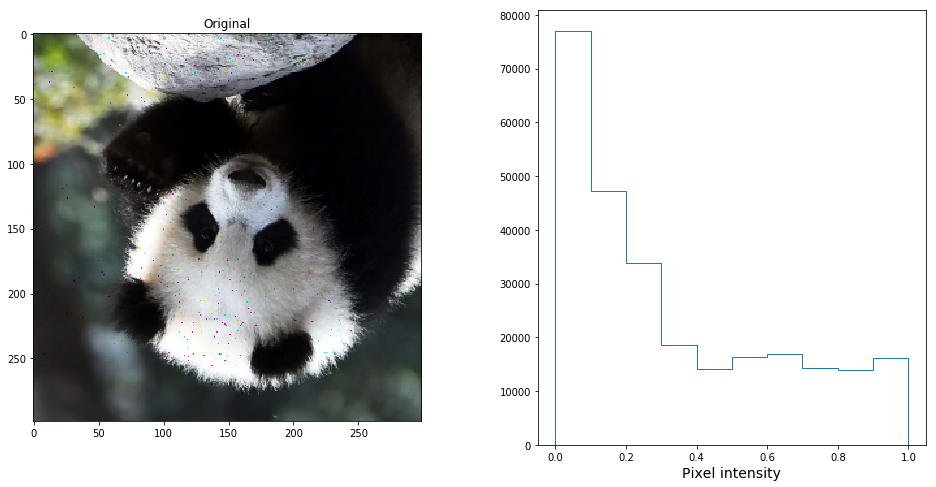

In [22]:
# 10. vertical flip
vertical_flip = input_resized_img[0][::-1, :]
show_image(vertical_flip)

(299, 299)


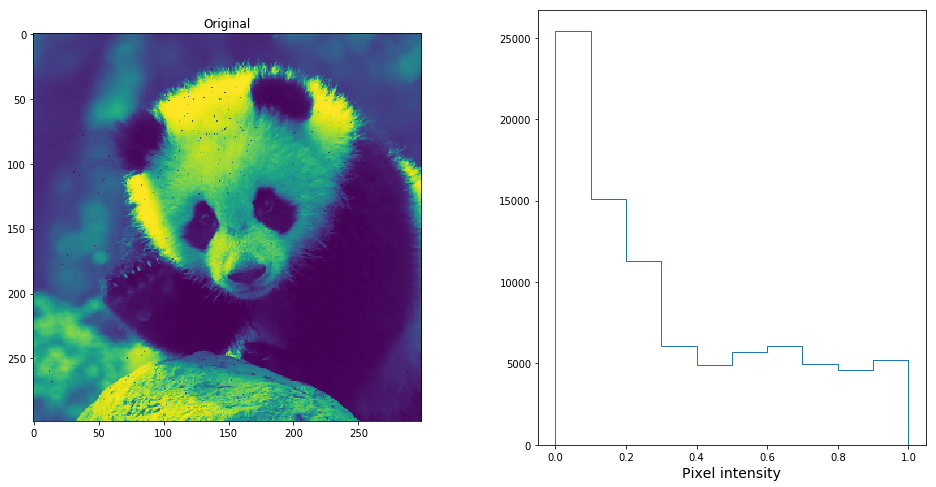

In [23]:
import skimage.color
gray = skimage.color.rgb2gray(input_resized_img[0])
print(gray.shape)
show_image(gray)

In [32]:
input_img = normalize(n_in_img).reshape((1, 299, 299, 3))

import json
tf.reset_default_graph()
sess = tf.Session()

with DeepInterpreter(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    # Compute class probability 
    yi = tf.nn.softmax(logits, 1)
    
    topk, idx = tf.nn.top_k(yi, k=3)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    input_X = input_img
    label_prob, index = sess.run((topk, idx), feed_dict={X: input_X})
    print(label_prob)
    for ix in index[0]:
        print(labels[str(ix)])

INFO:tensorflow:Restoring parameters from ../../deep_learning/data/models/inception_v3.ckpt
[[0.14780045 0.10835418 0.09589349]]
meerkat, mierkat
weasel
Arctic fox, white fox, Alopex lagopus


In [157]:
with DeepInterpreter(session=sess) as de:
    relevancy_scores = {
       'elrp': de.explain('elrp', tf.reduce_max(logits, 1), X, input_X),
    }
    print ("success...")

success...


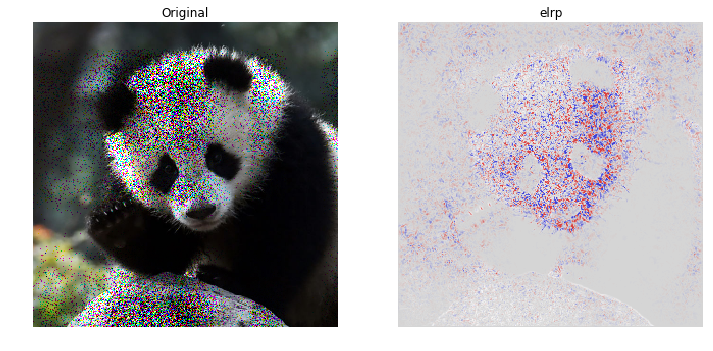

In [158]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt

xs = [input_X[0]]
n_cols = int(len(relevancy_scores)) + 1
n_rows = len(input_X) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original')
    ax.axis('off')
    for j, r_type in enumerate(relevancy_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevancy_scores[r_type][i], original_input_img=xi, axis=axj, percentile=99, alpha=.4).set_title(r_type)